In [1]:
# importovanje biblioteka koje ce nam biti potrebne kasnije
import numpy as np
import pandas as pd 
import time
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import shap

In [2]:
X_sm=pd.read_csv('D:\\Vlada\\Milica master\\X_sm_2.csv')
y_sm=pd.read_csv('D:\\Vlada\\Milica master\\y_sm_2.csv')
X_test=pd.read_csv('D:\\Vlada\\Milica master\\X_test_2.csv')
y_test=pd.read_csv('D:\\Vlada\\Milica master\\y_test_2.csv')

In [3]:
X_test.shape

(200, 6)

In [4]:
X_test.head()

,Credit amount,Duration,Housing_own,Saving accounts_little,Checking account_little,Checking account_moderate
0,-0.477788,-0.234548,0.635223,-1.208941,-0.613951,1.654786
1,-0.497625,-0.742595,0.635223,0.827170,-0.613951,1.654786
2,-0.810513,0.273499,0.635223,0.827170,1.628793,-0.604308
3,-0.032034,-0.234548,0.635223,0.827170,1.628793,-0.604308
4,-0.250607,0.527522,0.635223,-1.208941,-0.613951,1.654786


## Logisticka regresija

In [5]:
#trazimo najbolji regularizacioni parametar 
grid_model = LogisticRegression()
params = {'C': [10**i for i in range(-5, 5)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc', cv=5, return_train_score=True)

In [6]:
grid.fit(X_sm, y_sm)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             return_train_score=True, scoring='roc_auc')

In [7]:
grid.best_params_

{'C': 0.1}

In [8]:
log_reg = LogisticRegression(C = 0.1)

# Treniramo model na trening setu
log_reg.fit(X_sm, y_sm)

LogisticRegression(C=0.1)

In [9]:
log_reg_pred = log_reg.predict_proba(X_test)
log_reg_pred

array([[0.58205791, 0.41794209],
       [0.4685333 , 0.5314667 ],
       [0.29275502, 0.70724498],
       [0.35640986, 0.64359014],
       [0.50392067, 0.49607933],
       [0.45139201, 0.54860799],
       [0.42735838, 0.57264162],
       [0.49000136, 0.50999864],
       [0.32633512, 0.67366488],
       [0.63940646, 0.36059354],
       [0.70732575, 0.29267425],
       [0.30382088, 0.69617912],
       [0.79752472, 0.20247528],
       [0.5073178 , 0.4926822 ],
       [0.24214002, 0.75785998],
       [0.80146607, 0.19853393],
       [0.3067287 , 0.6932713 ],
       [0.85526622, 0.14473378],
       [0.63311412, 0.36688588],
       [0.77861797, 0.22138203],
       [0.7905118 , 0.2094882 ],
       [0.56106322, 0.43893678],
       [0.7497316 , 0.2502684 ],
       [0.20941798, 0.79058202],
       [0.29529111, 0.70470889],
       [0.42942616, 0.57057384],
       [0.87941851, 0.12058149],
       [0.78047378, 0.21952622],
       [0.55559254, 0.44440746],
       [0.74433068, 0.25566932],
       [0.

In [10]:
predicted = log_reg.predict(X_sm)
report = classification_report(y_sm, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       560
           1       0.68      0.74      0.71       560

    accuracy                           0.69      1120
   macro avg       0.70      0.69      0.69      1120
weighted avg       0.70      0.69      0.69      1120



In [11]:
predicted = log_reg.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.70      0.77       140
           1       0.52      0.75      0.61        60

    accuracy                           0.71       200
   macro avg       0.69      0.72      0.69       200
weighted avg       0.76      0.71      0.73       200



In [12]:
confusion_matrix(y_test, predicted)

array([[98, 42],
       [15, 45]], dtype=int64)

In [13]:
valid_auc = roc_auc_score(y_test, predicted)

In [14]:
valid_auc

0.7249999999999999

## Slucajna suma

In [15]:
#algoritam slucajne sume, parametri 100 stabala, n_jobs=-1 znaci da koristi sve procesore
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42, verbose = 1, n_jobs = -1)

In [16]:
#treniramo model
random_forest.fit(X_sm, y_sm)
features = list(X_sm.columns)
#izvlacimo najbitnije varijable
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

#predikcija na test setu
predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [17]:
predictions = random_forest.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [18]:
predicted_rf = random_forest.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [19]:
report_rf=classification_report(y_test,predicted_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       140
           1       0.47      0.57      0.51        60

    accuracy                           0.68       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.70      0.68      0.68       200



In [20]:
valid_auc_rf = roc_auc_score(y_test, predictions)

In [21]:
valid_auc_rf

0.6869642857142857

In [22]:
def plot_feature_importances(df):
    
    #sortiranje varijabli po znacaju
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalizujemo varijable da bi im suma bila 1
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    #bar chart
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    plt.xlabel('Normalizovan doprinos varijable'); plt.title('Znacajnost varijabli')
    plt.show()
    
    return df

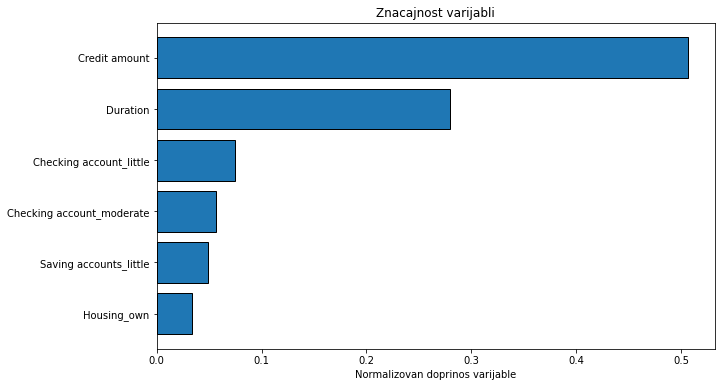

In [23]:
feature_importances_sorted = plot_feature_importances(feature_importances)

In [24]:
confusion_matrix(y_test, predicted_rf)

array([[101,  39],
       [ 26,  34]], dtype=int64)

## XGBoost

In [25]:
#Parametri za XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [26]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Vreme utroseno %i sati %i minuta i %s sekundi.' % (thour, tmin, round(tsec, 2)))

In [27]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(estimator=XGBClassifier(objective='binary:logistic'), param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_sm,y_sm), verbose=3, random_state=1001 )

start_time = timer(None)
random_search.fit(X_sm, y_sm)
timer(start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[16:40:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Vreme utroseno 0 sati 0 minuta i 1.74 sekundi.


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    1.6s finished


In [28]:
print('\n Rezultati:')
print(random_search.cv_results_)
print('\n Najbolji prediktor:')
print(random_search.best_estimator_)
print('\n Najbolji parametri:')
print(random_search.best_params_)


 Rezultati:
{'mean_fit_time': array([0.06562408, 0.10199348, 0.09009226, 0.08211366, 0.08111755]), 'std_fit_time': array([0.00293523, 0.00252452, 0.00477164, 0.00542195, 0.00046907]), 'mean_score_time': array([0.00465441, 0.00465401, 0.00498684, 0.00398946, 0.0043207 ]), 'std_score_time': array([4.70021655e-04, 9.40324293e-04, 8.14490730e-04, 1.94667955e-07,
       4.71316419e-04]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_

In [29]:
xgb_model =XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5,monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_model.fit(X_sm, y_sm, eval_set=[(X_test, y_test)], eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.74708
[1]	validation_0-auc:0.71839
[2]	validation_0-auc:0.69208
[3]	validation_0-auc:0.68095
[4]	validation_0-auc:0.65857
[5]	validation_0-auc:0.67119
[6]	validation_0-auc:0.67000
[7]	validation_0-auc:0.69018
[8]	validation_0-auc:0.69434
[9]	validation_0-auc:0.71256


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
predictions = xgb_model.predict_proba(X_test)[:, 1]

In [31]:
xgboost_roc_auc = roc_auc_score(y_test, predictions)

In [32]:
predicted_xgb = xgb_model.predict(X_test)

In [33]:
report_xgb=classification_report(y_test,predicted_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.88      0.60      0.71       140
           1       0.46      0.80      0.59        60

    accuracy                           0.66       200
   macro avg       0.67      0.70      0.65       200
weighted avg       0.75      0.66      0.67       200



In [34]:
xgboost_roc_auc

0.7470833333333333

In [35]:
#izvlacimo najbitnije varijable
feature_importance_values = xgb_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

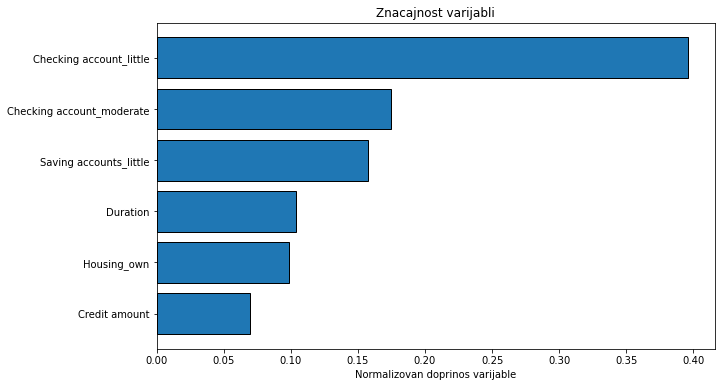

In [36]:
feature_importances_sorted = plot_feature_importances(feature_importances)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


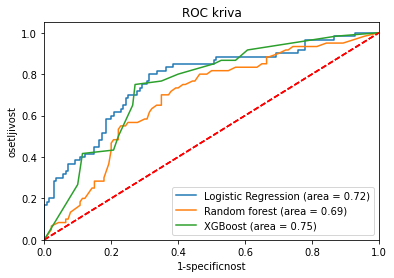

In [37]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, random_forest.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr_rf, tpr_rf, label='Random forest (area = %0.2f)' % valid_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % xgboost_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-specificnost')
plt.ylabel('osetljivost')
plt.title('ROC kriva')
plt.legend(loc="lower right")
plt.show()


## Interpretabilnost

In [38]:
explainer = shap.TreeExplainer(xgb_model,X_sm,model_output='probability')
shap_values = explainer.shap_values(X_sm)

In [39]:
xgb_model.predict_proba(np.array(X_sm.iloc[1,:]).reshape((1,-1)))

array([[0.59465086, 0.4053491 ]], dtype=float32)

In [40]:
shap.initjs()

In [41]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sm.iloc[0,:])

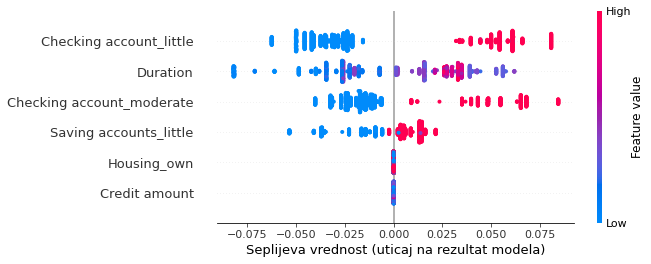

In [42]:
shap.summary_plot(shap_values, X_sm, show=False)
plt.xlabel("Seplijeva vrednost (uticaj na rezultat modela)")
plt.show()